# Experiments

### Setup

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

MODEL_NAME = "gpt-3.5-turbo"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langsmith import evaluate, Client
from tqdm.auto import tqdm

tqdm().disable = True

client = Client()
dataset_name = "barcelona_data"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

0it [00:00, ?it/s]

View the evaluation results for experiment: 'gpt-4o-cae1c8f0' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=51c3ef88-bb61-4510-a109-a97a216e832b




0it [00:00, ?it/s]Error running target function: X has 1536 features, but NearestNeighbors is expecting 384 features as input.
Traceback (most recent call last):
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\run_helpers.py", line 693, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "C:\Users\jaind\AppData\Local\Temp\ipykernel_30280\2300649378.py", line 14, in target_function
    return langsmith_rag(inputs["question"])
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith

,inputs.question,outputs.output,error,reference.output,feedback.wrapper,execution_time,example_id,id
0,What was the broader legacy of Barcelona’s 200...,None,"ValueError('X has 1536 features, but NearestNe...",It influenced a generation of positional play ...,None,0.690915,12c846c9-6819-4420-b0c5-1f5766663411,ffcc555e-868d-402b-9921-03b01792da6f
1,Who scored for Barcelona in the 2009 Champions...,None,"ValueError('X has 1536 features, but NearestNe...",Samuel Eto’o opened the scoring and Lionel Mes...,None,0.415251,165a9264-a137-47bd-84c7-6867bc83ba8f,39088856-ecec-4cc5-949c-0919a180bbd0
2,How did Guardiola integrate Busquets during th...,None,"ValueError('X has 1536 features, but NearestNe...",Guardiola promoted Sergio Busquets into the fi...,None,1.791257,2d4cdcdb-e142-493b-9e35-42863b09a7b3,6a3ee164-80b1-44ba-926f-53604465ddb4
3,What is FC Barcelona’s sextuple in one paragraph?,None,"ValueError('X has 1536 features, but NearestNe...",FC Barcelona’s sextuple refers to winning six ...,None,0.621457,2f9db0ae-6dba-4358-b627-990672b422b3,1a74bdc8-85b4-4b66-a2a0-24300ba8aec8
4,Summarize Messi’s impact during the sextuple y...,None,"ValueError('X has 1536 features, but NearestNe...",Messi delivered decisive goals and chance crea...,None,0.410866,3a3cedc4-d0e3-4fdc-8f02-d60abcf40ccc,38709662-986a-4624-8600-0bfeba8531d0
5,Who were Barcelona’s typical midfield three in...,None,"ValueError('X has 1536 features, but NearestNe...","Xavi Hernández, Andrés Iniesta, and Sergio Bus...",None,0.398321,3c9839dc-98f9-4dd3-b1a1-9fb86793730a,825dba43-51e9-428d-917a-0599f5ac1789
6,What tactical identity defined Barcelona’s sex...,None,"ValueError('X has 1536 features, but NearestNe...","Positional play with high pressing, quick circ...",None,0.464470,4b5fe6c5-18c4-4001-8b9b-593e326b75b3,ccd2f35c-0ea0-4961-9bc7-cc9845a192df
7,What role did La Masia graduates play in the s...,None,"ValueError('X has 1536 features, but NearestNe...","La Masia graduates like Messi, Xavi, Iniesta, ...",None,0.420481,76c7a425-06c9-4278-810e-a6cce027b0e0,37addeb3-96c1-42bb-a526-b7f364b4b363
8,Name three key players central to the sextuple...,None,"ValueError('X has 1536 features, but NearestNe...","Lionel Messi, Xavi Hernández, and Andrés Inies...",None,0.425656,7a683d4e-4b92-4147-ab0b-3df8bc03c8e9,67fc26b5-159a-40ae-86f7-3fc0f59a8226
9,What is the difference between a treble and a ...,None,"ValueError('X has 1536 features, but NearestNe...",A treble is three major trophies in a season (...,None,0.469741,7beff236-e7e5-4f25-a24d-4bb8ce438bfa,194fe762-8602-453c-9784-50d3534e1edf


In [4]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-488ea510' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=ed6114d9-567b-4966-a103-f2865ed0d9a5




0it [00:00, ?it/s]Error running target function: X has 1536 features, but NearestNeighbors is expecting 384 features as input.
Traceback (most recent call last):
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\run_helpers.py", line 693, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "C:\Users\jaind\AppData\Local\Temp\ipykernel_30280\862480817.py", line 5, in target_function
    return langsmith_rag(inputs["question"])
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.

,inputs.question,outputs.output,error,reference.output,feedback.wrapper,execution_time,example_id,id
0,What was the broader legacy of Barcelona’s 200...,None,"ValueError('X has 1536 features, but NearestNe...",It influenced a generation of positional play ...,None,0.500337,12c846c9-6819-4420-b0c5-1f5766663411,396b8c78-5682-4cb8-a273-50de9f3bd8be
1,Who scored for Barcelona in the 2009 Champions...,None,"ValueError('X has 1536 features, but NearestNe...",Samuel Eto’o opened the scoring and Lionel Mes...,None,0.418573,165a9264-a137-47bd-84c7-6867bc83ba8f,21ab4478-96a9-4861-b330-cdb4447791da
2,How did Guardiola integrate Busquets during th...,None,"ValueError('X has 1536 features, but NearestNe...",Guardiola promoted Sergio Busquets into the fi...,None,0.431925,2d4cdcdb-e142-493b-9e35-42863b09a7b3,1c7c72a2-24aa-478c-89e8-6d715758ddba
3,What is FC Barcelona’s sextuple in one paragraph?,None,"ValueError('X has 1536 features, but NearestNe...",FC Barcelona’s sextuple refers to winning six ...,None,0.416524,2f9db0ae-6dba-4358-b627-990672b422b3,06c7367a-a2e0-478e-9c55-8c9744681093
4,Summarize Messi’s impact during the sextuple y...,None,"ValueError('X has 1536 features, but NearestNe...",Messi delivered decisive goals and chance crea...,None,0.404098,3a3cedc4-d0e3-4fdc-8f02-d60abcf40ccc,6fe02368-769f-4b4f-ae4e-ae99bcf209f4
5,Who were Barcelona’s typical midfield three in...,None,"ValueError('X has 1536 features, but NearestNe...","Xavi Hernández, Andrés Iniesta, and Sergio Bus...",None,0.415493,3c9839dc-98f9-4dd3-b1a1-9fb86793730a,a3bb7354-7c23-4a8d-a0ef-f5464278490e
6,What tactical identity defined Barcelona’s sex...,None,"ValueError('X has 1536 features, but NearestNe...","Positional play with high pressing, quick circ...",None,0.367230,4b5fe6c5-18c4-4001-8b9b-593e326b75b3,d23bd9bf-1bf4-434e-bbcd-460f0805e294
7,What role did La Masia graduates play in the s...,None,"ValueError('X has 1536 features, but NearestNe...","La Masia graduates like Messi, Xavi, Iniesta, ...",None,0.403173,76c7a425-06c9-4278-810e-a6cce027b0e0,f5e8be6c-c401-41d0-862e-6e12d89ea485
8,Name three key players central to the sextuple...,None,"ValueError('X has 1536 features, but NearestNe...","Lionel Messi, Xavi Hernández, and Andrés Inies...",None,0.428894,7a683d4e-4b92-4147-ab0b-3df8bc03c8e9,ea9606ed-a6c2-4f71-9fd1-fc7b7b73ec3d
9,What is the difference between a treble and a ...,None,"ValueError('X has 1536 features, but NearestNe...",A treble is three major trophies in a season (...,None,0.450142,7beff236-e7e5-4f25-a24d-4bb8ce438bfa,65351f76-a057-4fca-8c87-2b790e8a53c6


In [5]:
evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name,
        example_ids=[   # We pass in a specific list of example_ids
            "12c846c9-6819-4420-b0c5-1f5766663411",
            "76c7a425-06c9-4278-810e-a6cce027b0e0",
            "987eca78-d74d-4270-833b-69fa8b1d0e99"
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="three specific example ids"
)

View the evaluation results for experiment: 'three specific example ids-c007449a' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=88bc284a-cfe0-4140-bf4e-2b5fd18d2399




0it [00:00, ?it/s]Error running target function: X has 1536 features, but NearestNeighbors is expecting 384 features as input.
Traceback (most recent call last):
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\run_helpers.py", line 693, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "C:\Users\jaind\AppData\Local\Temp\ipykernel_30280\862480817.py", line 5, in target_function
    return langsmith_rag(inputs["question"])
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.

,inputs.question,outputs.output,error,reference.output,feedback.wrapper,execution_time,example_id,id
0,What was the broader legacy of Barcelona’s 200...,None,"ValueError('X has 1536 features, but NearestNe...",It influenced a generation of positional play ...,None,0.547037,12c846c9-6819-4420-b0c5-1f5766663411,5d07bb59-7047-4f4c-b476-2eae674e4d70
1,What role did La Masia graduates play in the s...,None,"ValueError('X has 1536 features, but NearestNe...","La Masia graduates like Messi, Xavi, Iniesta, ...",None,0.406424,76c7a425-06c9-4278-810e-a6cce027b0e0,15ebabc3-446f-4bb6-b4b3-2890f202bd3b
2,List the six trophies in a single comma-separa...,None,"ValueError('X has 1536 features, but NearestNe...","La Liga, Copa del Rey, UEFA Champions League, ...",None,0.395230,987eca78-d74d-4270-833b-69fa8b1d0e99,fc899f1c-25cd-4e33-b556-18d7f4236da9


In [6]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-6ef66d91' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=758455ba-77f7-4c4b-a038-65bdeee44b1c




0it [00:00, ?it/s]Error running target function: X has 1536 features, but NearestNeighbors is expecting 384 features as input.
Traceback (most recent call last):
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1923, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
    ~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\langsmith\run_helpers.py", line 693, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "C:\Users\jaind\AppData\Local\Temp\ipykernel_30280\862480817.py", line 5, in target_function
    return langsmith_rag(inputs["question"])
  File "c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.

,inputs.question,outputs.output,error,reference.output,feedback.wrapper,execution_time,example_id,id
0,How did Guardiola integrate Busquets during th...,None,"ValueError('X has 1536 features, but NearestNe...",Guardiola promoted Sergio Busquets into the fi...,None,0.441574,2d4cdcdb-e142-493b-9e35-42863b09a7b3,86e8d70e-0fb2-419e-93c1-4dce006d0054
1,Who scored for Barcelona in the 2009 Champions...,None,"ValueError('X has 1536 features, but NearestNe...",Samuel Eto’o opened the scoring and Lionel Mes...,None,0.636363,165a9264-a137-47bd-84c7-6867bc83ba8f,30a9dc20-860d-4796-9dee-3f1ff37ba7df
2,What was the broader legacy of Barcelona’s 200...,None,"ValueError('X has 1536 features, but NearestNe...",It influenced a generation of positional play ...,None,0.643691,12c846c9-6819-4420-b0c5-1f5766663411,61047729-9b27-462f-adcd-90e547b38e0b
3,What is FC Barcelona’s sextuple in one paragraph?,None,"ValueError('X has 1536 features, but NearestNe...",FC Barcelona’s sextuple refers to winning six ...,None,0.521018,2f9db0ae-6dba-4358-b627-990672b422b3,827b3ca7-56f4-4a74-8ca8-4b73d7304363
4,Who were Barcelona’s typical midfield three in...,None,"ValueError('X has 1536 features, but NearestNe...","Xavi Hernández, Andrés Iniesta, and Sergio Bus...",None,0.479781,3c9839dc-98f9-4dd3-b1a1-9fb86793730a,cc07ae81-f9a5-41b0-84e9-c4c43bf9c43d
5,Summarize Messi’s impact during the sextuple y...,None,"ValueError('X has 1536 features, but NearestNe...",Messi delivered decisive goals and chance crea...,None,0.488206,3a3cedc4-d0e3-4fdc-8f02-d60abcf40ccc,a68e6a43-b17b-4a22-a10c-8ceac3cd2832
6,What tactical identity defined Barcelona’s sex...,None,"ValueError('X has 1536 features, but NearestNe...","Positional play with high pressing, quick circ...",None,0.523674,4b5fe6c5-18c4-4001-8b9b-593e326b75b3,37d04bdd-79f1-4a53-86f7-a4dbeaacebbc
7,What role did La Masia graduates play in the s...,None,"ValueError('X has 1536 features, but NearestNe...","La Masia graduates like Messi, Xavi, Iniesta, ...",None,0.426737,76c7a425-06c9-4278-810e-a6cce027b0e0,ec0e8963-8300-42d4-8271-9f9689c07431
8,Name three key players central to the sextuple...,None,"ValueError('X has 1536 features, but NearestNe...","Lionel Messi, Xavi Hernández, and Andrés Inies...",None,0.471493,7a683d4e-4b92-4147-ab0b-3df8bc03c8e9,adedf7bc-5bc6-41eb-a37a-910ab2f18ebd
9,What is the difference between a treble and a ...,None,"ValueError('X has 1536 features, but NearestNe...",A treble is three major trophies in a season (...,None,0.402688,7beff236-e7e5-4f25-a24d-4bb8ce438bfa,63286743-7ad6-4f60-b478-60ea6ca8cb30


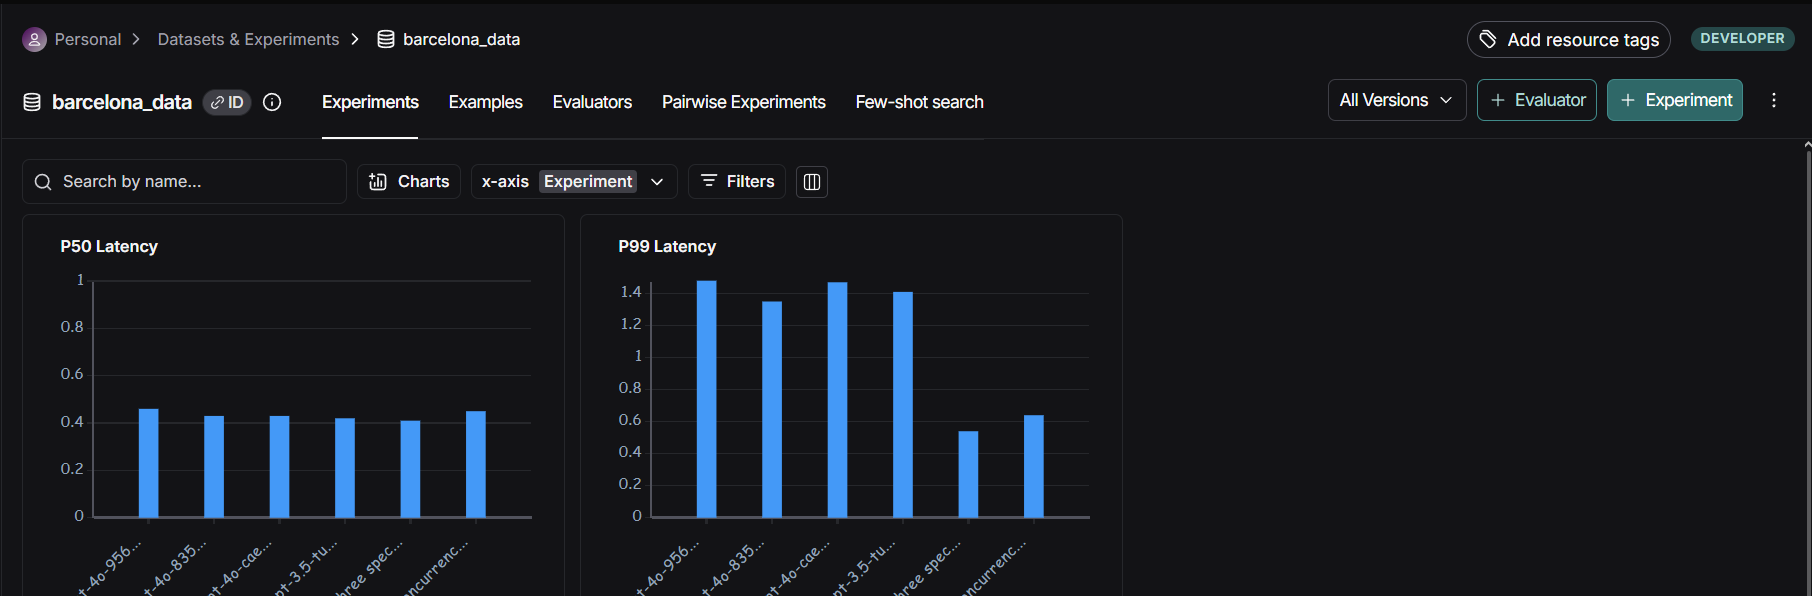